# <font color=blue> __Single-cell RNA-seq data analysis using SCANPY__  </font>
MLBI-lab, July 21, 2025

- 이 주피터 노트북은 단일세포 RNA-seq 데이터를 분석하기 위한 기초 실습을 포함합니다.
- SCANPY를 이용한 전처리, 시각화를 위한 기본적인 처리 과정에 대한 코드 예제를 제공합니다.
- Google Colab에서 실습하는 것을 가정하고 만들었으나 Anaconda 등이 설치된 개인 컴퓨터에서도 사용할 수 있습니다.

## __1. Install required packages and import them__
이제 파일이 준비되었으니 필요한 패키지를 설치하고 이를 불러와서(import해서) 데이터를 들여다 볼 수 있습니다.

In [ ]:
## 필요한 패키지 설치 (이미 설치되었다면 skip 해도 됩니다.)
'''
!pip install gdown
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install scikit-network
'''
!pip install scanpy 
!pip install scoda-viz

In [1]:
## 필요한 패키지 불러오기
import copy, warnings, os
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scodaviz import load_sample_data, plot_sankey

warnings.filterwarnings('ignore')

## __2A. Download a sample data__

In [2]:
adata = load_sample_data( 'Breast' )
adata

Downloading...
From (original): https://drive.google.com/uc?export=download&id=17FHZSTbvu9CO0pns5-3hcKl2LgLI7JF8
From (redirected): https://drive.google.com/uc?export=download&id=17FHZSTbvu9CO0pns5-3hcKl2LgLI7JF8&confirm=t&uuid=eba4bd87-4e49-45b2-853c-12130e5d7e29
To: /mnt/HDD2/Google_drive/git/scoda_explorer/Notebooks/downloaded
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124M/124M [00:12<00:00, 9.55MB/s]


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset'

## __2A. Or, Load your h5ad file__

In [2]:
file_h5ad = 'BRCA_GSE161529_33K_v1.h5ad'

In [3]:
adata = sc.read_h5ad(file_h5ad)
adata

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset'

#### This dataset contains several pieces of preprocessed information, which we remove to start from scratch.

In [84]:
lst = ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sid',
       'tissue', 'celltype_major', 'celltype_minor', 'celltype_subset']
lst = list(set(lst).intersection(adata.obs.columns.values))
adata.obs.drop( columns = lst, inplace = True )
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes', 'cluster'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'cluster', 'condition_colors', 'cluster_colors', 'sample_colors', 't-test', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## __3. Check your data__

#### __AnnData Format__
  
<div>
<img src="https://drive.google.com/uc?export=view&id=1IGjZpO_DeaNFiX3u_fy_rnPC1oKwVsqU" align="center" width="500"/>
</div>
<div>
<img src="attachment:fefeae20-ad05-4cea-8327-72f3dd19903f.png" width="500"/>
</div>

https://anndata.readthedocs.io/en/stable/

#### __Basic operations__
1. cell selection, gene selection (supports boolean indexing as for DataFrame)
3. writing to a file
4. getting cell-by-gene count matrix as a data frame
5. adding an annotation

In [5]:
adata.obs.head()

,Patient,Description,Source,Condition,Menopause,Parity,Gender,geo_no,subtype,subtype_detail,condition,sample
GSM4909302_ER.MH0025_AGTCTTTGTTACCGAT-1,ER-MH0025,"ER+ tumor, total cells",Total,ER+ tumor,NaN,NaN,Female,GSM4909302,ER+,ER+,ER+,ER-MH0025
GSM4909302_ER.MH0025_CGGTTAACACGTCAGC-1,ER-MH0025,"ER+ tumor, total cells",Total,ER+ tumor,NaN,NaN,Female,GSM4909302,ER+,ER+,ER+,ER-MH0025
GSM4909302_ER.MH0025_GTTTCTACATCGATTG-1,ER-MH0025,"ER+ tumor, total cells",Total,ER+ tumor,NaN,NaN,Female,GSM4909302,ER+,ER+,ER+,ER-MH0025
GSM4909302_ER.MH0025_TATCTCAGTGGCTCCA-1,ER-MH0025,"ER+ tumor, total cells",Total,ER+ tumor,NaN,NaN,Female,GSM4909302,ER+,ER+,ER+,ER-MH0025
GSM4909302_ER.MH0025_ACTTTCATCCGCGCAA-1,ER-MH0025,"ER+ tumor, total cells",Total,ER+ tumor,NaN,NaN,Female,GSM4909302,ER+,ER+,ER+,ER-MH0025


In [6]:
adata.var.head()

""
AL627309.1
AL669831.5
FAM87B
LINC00115
FAM41C


In [7]:
adata.obs[['condition']].value_counts()

condition
ER+          8994
Normal       8965
TNBC         8283
HER2+        7500
Name: count, dtype: int64

In [8]:
adata.obs[['sample']].value_counts()

sample        
ER-MH0025         1500
ER-MH0029-7C      1500
ER-MH0043-T       1500
ER-MH0114-T3      1500
ER-MH0173-T       1500
HER2-AH0308       1500
HER2-MH0031       1500
N-MH275-Total     1500
HER2-MH0161       1500
HER2-MH0176       1500
HER2-PM0337       1500
N-PM0019-Total    1500
N-MH288-Total     1500
TN-B1-MH0177      1500
TN-MH0126         1499
TN-B1-Tum0554     1499
ER-MH0151         1494
N-PM0233-Total    1492
N-PM0372-Total    1488
N-PM0230-Total    1485
TN-MH0135         1398
TN-B1-MH0131      1237
TN-B1-MH4031      1150
Name: count, dtype: int64

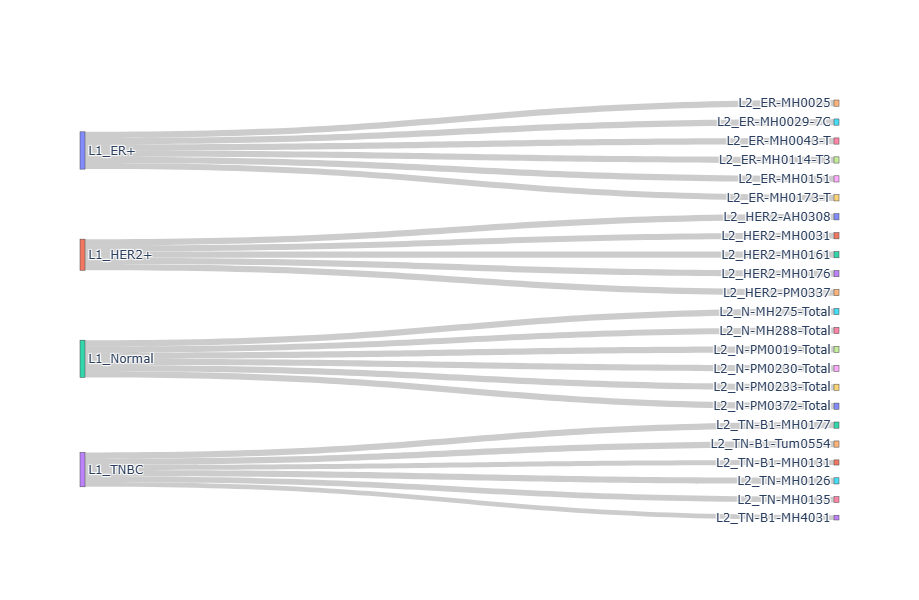

In [11]:
lst = [adata.obs['condition'], adata.obs['sample']]
plot_sankey(lst, title=None, fs=12, WH=(400, 600), th=30, title_y=0.85 )

## __4. Filtering cells and genes__
#### __Get statistics for Cell/Gene filtering__

In [12]:
adata

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample'

In [13]:
## select genes of which the name start with 'MT-', i.e., mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
## Boolean values saved to the new column named, 'mt' in var

In [14]:
## Check the number of mitochondrial genes
display(adata.var['mt'].sum())

13

In [15]:
## Get stats
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, \
                           log1p = False, inplace = True)

adata
## Results of this function are stored in new columns in the obs field

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

pp.calculate_qc_metrics: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html 

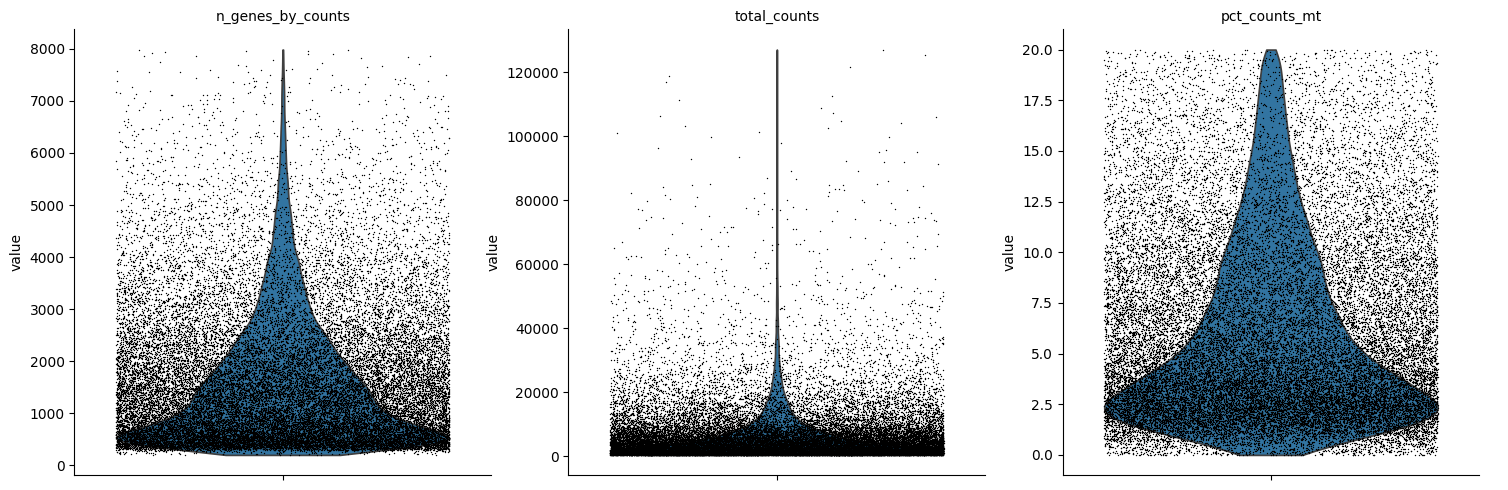

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [17]:
adata.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].median()

n_genes_by_counts    1268.000000
total_counts         3516.000000
pct_counts_mt           4.536538
dtype: float64

#### __Cell/Gene filtering__
- cell-by-gene count matrix에서 각 gene이 발현된 cell 수가 너무 적은 것은 제거
- 이를 위해 cell-by-gene count matrix를 data frame으로 가져와서
- 각 gene에 대해 0보다 큰 cell의 수를 계산하여
- 이 수를 기준으로 조건을 만들어서 filtering 함

#### Easy way to cell/gene filtering

In [19]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_cells(adata, max_genes = 4000)
sc.pp.filter_genes(adata, min_cells = 20)

adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

## __5. Basic processings__

#### 이후의 processing은 cell-by-gene count matrix의 값을 바꾸므로 raw count 값을 따로 저장해 놓음

In [20]:
## adata의 raw count가 나중에 필요힐 수 있으므로 사본을 만들어서 adata.raw에 저장
# adata.raw = adata.copy()
## 나중에 adata 저장시 adata.raw도 같이 저장됨

adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

#### __2차원 시각화(UMAP 또는 tSNE)를 위한 몇 가지 routine 한 step__
1. Count normalization: 각 행의 합(각 cell에 대한 RNA count의 총합)을 동일한 값(예 10,000)으로 맞춤
2. 1-augmented log-transform: Raw count의 확률분포를 정규분포에 가깝게 변환 (log변환 전 1을 더함)
3. highly variable gene selection: cell마다 값들의 변동이 큰 gene들을 확인하여 var field의 열('variable_gene')에 저장
4. Dimension reduction using PCA: 선형변환 방식인 PCA를 이용하여 각 cell의 expression pattern(X의 각 행)을 차원 축소 -> obsm['X_pca']에 저장됨. (_Note:_ PCA를 위한 차원은 소위 'explained variance' plot을 보고 결정하면 좋지만 대략 15정도로 설정해도 무방함.)
5. Building Neighbor graph: PCA로 차원 축소한 벡터를 이용하여, 각 cell에 대해 expression pattern이 유사한 k개의 cell을 선택하여 이를 sparse matrix 형태로 저장 (matrix 크기는 cell수xcell수 이며 obsp field에 sparse matrix로 저장 됨.
6. UMAP or tSNE projection: Neighbor graph까지 얻어졌으면 umap 또는 tsne를 이용하여 2차원으로 차원 축소하여 산점도 확인 가능
7. Clustering: 비슷한 expression pattern을 갖는 cell들을 하나의 클러스터로 그룹핑

In [21]:
## 1. Count normalization
sc.pp.normalize_total(adata, target_sum=1e4)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [22]:
## 2. 1-augmented log-transform
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

In [23]:
## 3. highly variable gene selection
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

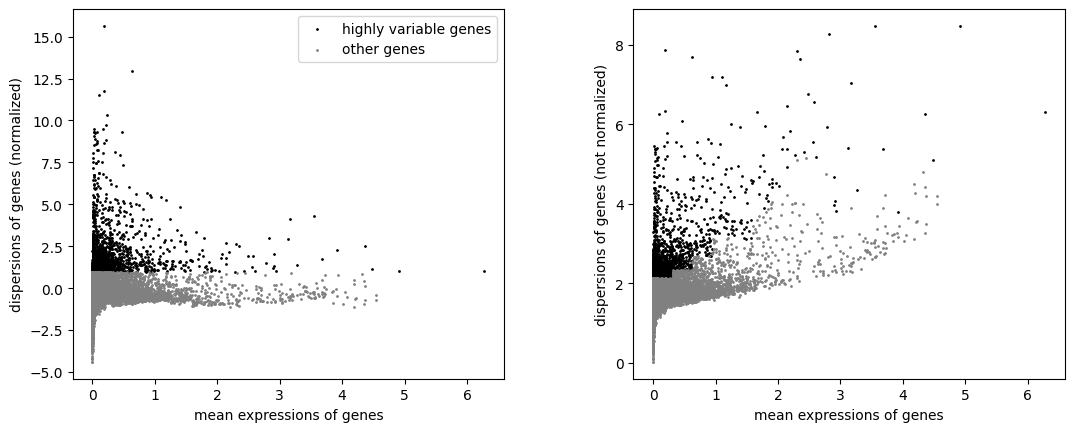

In [24]:
## check stats of highly-variable genes
sc.pl.highly_variable_genes(adata)

In [25]:
## 4. Dimension reduction using PCA
sc.tl.pca(adata, n_comps = 15, use_highly_variable = True)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [26]:
## 5. Building Neighbor graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15, use_rep = 'X_pca')
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:
## 6a: UMAP projection
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [28]:
## 6b: tSNE projection (시간이 좀 걸림)
sc.tl.tsne(adata)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [30]:
## 7: Clustering using leiden algorithm
sc.tl.leiden(adata, resolution = 0.2, key_added = 'cluster')
## The clustering resolution was intentionally set low for quick example. Default value is 1.
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'cluster'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'cluster'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## __6. Visualization__

#### 이제 UMAP 또는 tSNE 좌표를 이용해 대체적인 분포를 시각화해 볼 수 있습니다.

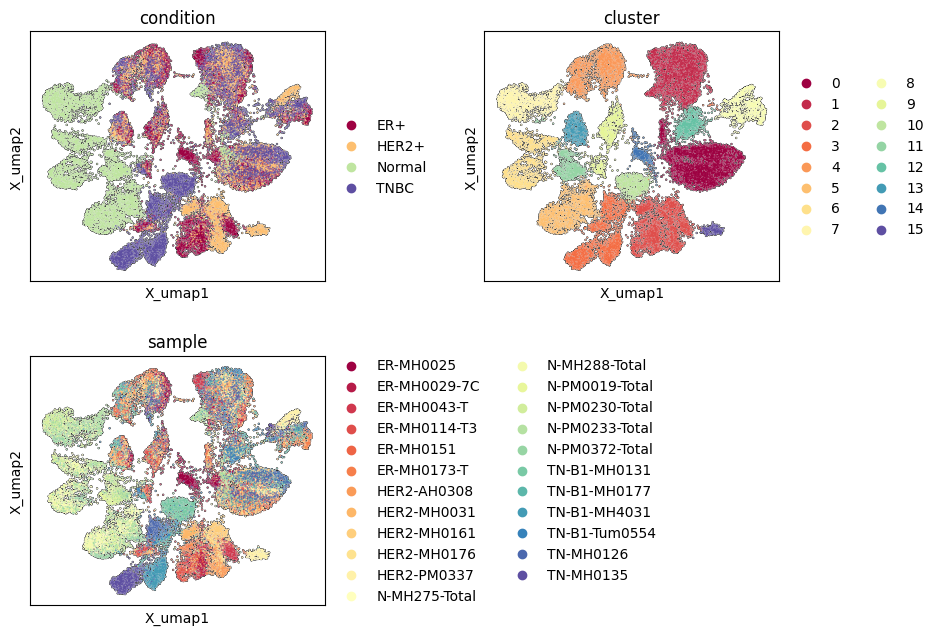

In [31]:
items_to_plot = ['condition', 'cluster', 'sample']

plt.rcParams['figure.figsize'] = (3.5, 3.5)
sc.pl.embedding( adata, color = items_to_plot, 
                 basis = 'X_umap', neighbors_key = 'neighbors',
                 wspace = 0.4, hspace = 0.3, legend_fontsize = 10,
                 ncols = 2, palette = 'Spectral', add_outline = True)

#### 잘 알려진 몇가지 marker gene들의 발현량을 보면 어느 cluster가 무슨 세포유형인지 대략적으로 확인 가능

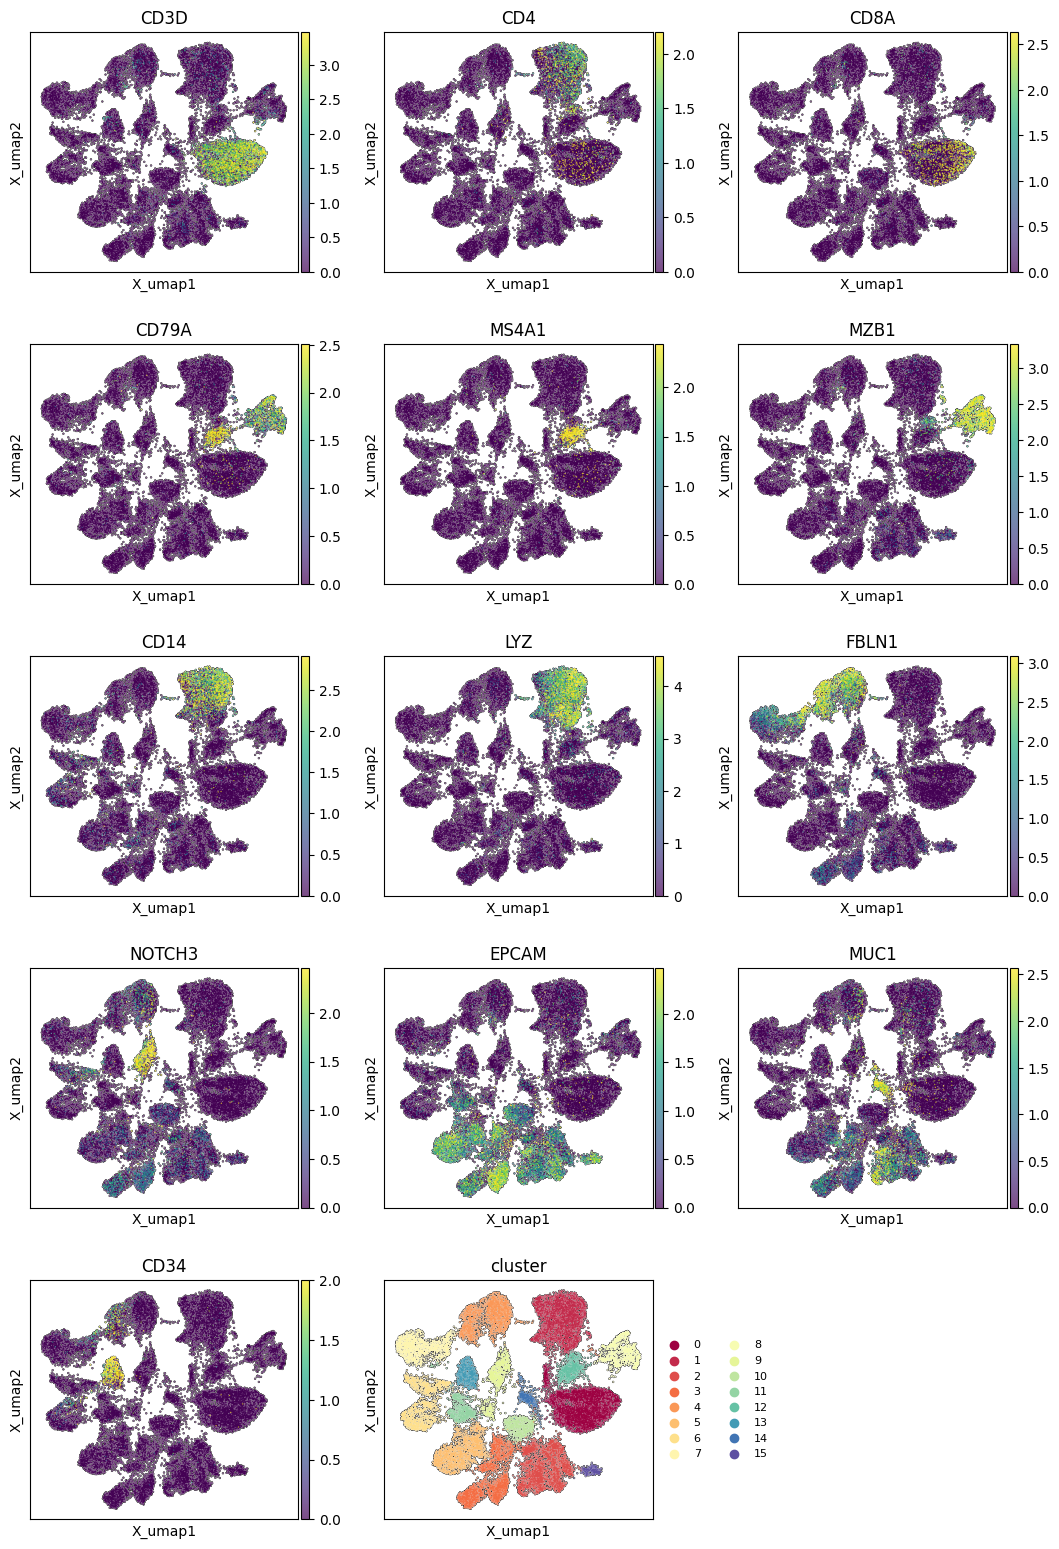

In [42]:
items_to_plot = ['CD3D', 'CD4', 'CD8A',     ## T cell markers
                 'CD79A', 'MS4A1', 'MZB1',  ## B cell markers
                 'CD14', 'LYZ',             ## Myeloid cell markers
                 'FBLN1', 'NOTCH3',         ## Stromal cells (Fibroblast, Smooth muscle cell) markers
                 'EPCAM', 'MUC1',           ## Epithelial cell markers
                 'CD34']                    ## Endothelial cell marker 


plt.rcParams['figure.figsize'] = (3.5, 3.5)
sc.pl.embedding( adata, color = items_to_plot + ['cluster'], use_raw = False,
                 basis = 'X_umap', neighbors_key = 'neighbors',
                 wspace = 0.2, hspace = 0.3, legend_fontsize = 8,
                 ncols = 3, palette = 'Spectral', add_outline = True, vmax = 'p99', vmin = 0)

#### Cluster 별 manual cell-type annotation을 할 때 요런 plot을 먼저 봅니다.

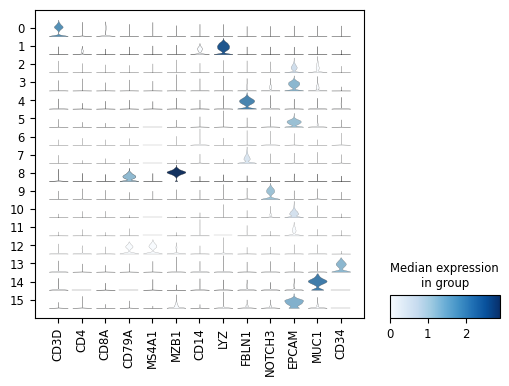

In [37]:
sc.pl.stacked_violin(adata, items_to_plot, groupby='cluster', figsize = (6,4))

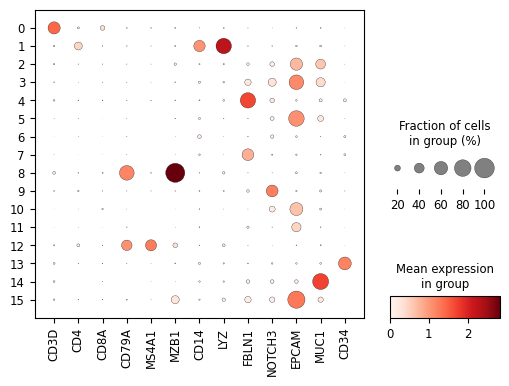

In [46]:
sc.pl.dotplot(adata, items_to_plot, groupby='cluster', figsize = (6,4))

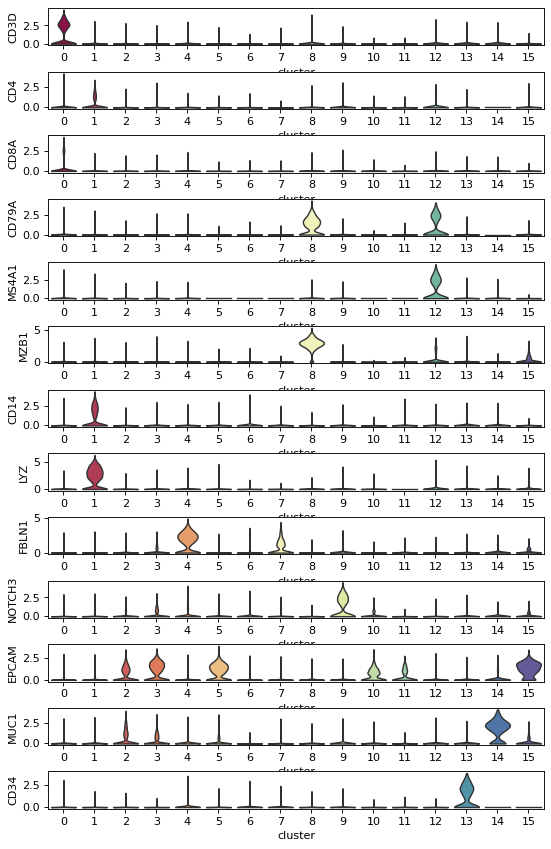

In [44]:
fig, axes = plt.subplots(len(items_to_plot), 1, figsize=(8, 1*len(items_to_plot)), dpi = 80)
plt.subplots_adjust(hspace = 0.9)

for j, item in enumerate(items_to_plot):
    sc.pl.violin(adata, [item], groupby='cluster', ax = axes[j], use_raw = False, stripplot = False, show = False)

Unknown type for standard_scale, ignored


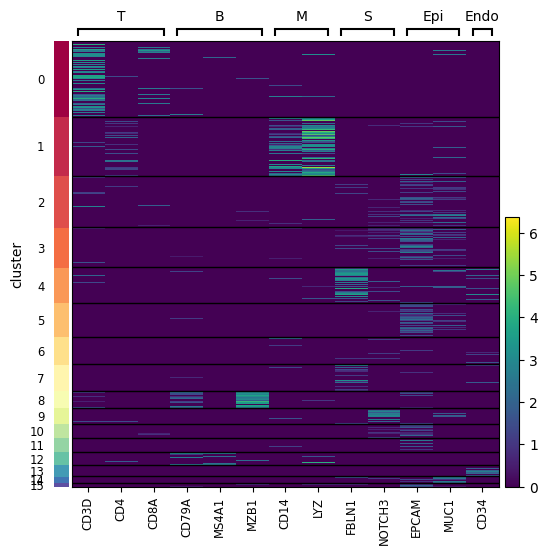

In [64]:
items_to_plot = {'T': ['CD3D', 'CD4', 'CD8A'],     ## T cell markers
                 'B': ['CD79A', 'MS4A1', 'MZB1'],  ## B cell markers
                 'M': ['CD14', 'LYZ'],             ## Myeloid cell markers
                 'S': ['FBLN1', 'NOTCH3'],         ## Stromal cells (Fibroblast, Smooth muscle cell) markers
                 'Epi': ['EPCAM', 'MUC1'],           ## Epithelial cell markers
                 'Endo': ['CD34'] }                   ## Endothelial cell marker 


sc.pl.heatmap( adata, var_names = items_to_plot, groupby = 'cluster', 
               var_group_labels = items_to_plot.keys(),
               standard_scale = True, figsize = (6, 6) )

## __7. DEG Analysis (among clusters)__

In [78]:
test_sel = 'wilcoxon'  ## 'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'
sc.tl.rank_genes_groups(adata, groupby = 'cluster', method=test_sel, 
                        key_added = test_sel, pts = True)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'cluster'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'cluster', 'condition_colors', 'cluster_colors', 'sample_colors', 't-test', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### Get DEG results in data frame

In [79]:
target_cluster = '0'
gene_rank = sc.get.rank_genes_groups_df(adata, group = target_cluster,
                                        key = test_sel, pval_cutoff = 0.01,
                                        log2fc_min = 0.25)

In [80]:
gene_rank.iloc[:30]

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,B2M,85.440399,2.238854,0.0,0.0,0.996656,0.946984
1,TMSB4X,76.004646,2.331124,0.0,0.0,0.993311,0.932608
2,CD52,69.956917,4.926818,0.0,0.0,0.659049,0.093519
3,RPS27,68.527130,1.109352,0.0,0.0,0.992568,0.981593
4,BTG1,68.174644,2.384834,0.0,0.0,0.823671,0.669849
5,CXCR4,61.081741,3.763967,0.0,0.0,0.638610,0.206625
6,HLA-A,60.603443,1.818298,0.0,0.0,0.863805,0.752491
7,HLA-B,60.586033,1.797624,0.0,0.0,0.900037,0.778505
8,CD3D,59.572445,6.506124,0.0,0.0,0.527685,0.023503
9,IL32,56.933662,3.655069,0.0,0.0,0.597733,0.217882


In [81]:
target_cluster = '1'
gene_rank = sc.get.rank_genes_groups_df(adata, group = target_cluster,
                                        key = test_sel, pval_cutoff = 0.01,
                                        log2fc_min = 0.25)

In [82]:
gene_rank.iloc[:30]

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,TYROBP,95.799141,7.622290,0.0,0.0,0.934720,0.040482
1,HLA-DRA,93.937866,6.303285,0.0,0.0,0.948111,0.248454
2,FTL,93.838348,3.928355,0.0,0.0,0.997131,0.901288
3,CD74,93.486374,5.489856,0.0,0.0,0.964371,0.380847
4,FCER1G,88.804939,6.904964,0.0,0.0,0.873984,0.046628
5,HLA-DRB1,85.241325,5.313320,0.0,0.0,0.886896,0.214883
6,HLA-DPA1,83.251251,5.527786,0.0,0.0,0.855093,0.164218
7,HLA-DPB1,80.571251,5.298014,0.0,0.0,0.837159,0.177275
8,AIF1,80.107605,7.846039,0.0,0.0,0.776184,0.015785
9,PSAP,78.364548,3.529521,0.0,0.0,0.887374,0.485124
